In [134]:
from fastai.text.all import *
import pandas as pd
cols = ["sentiment","text"]
df = pd.read_csv("data/all-data.csv", names =cols, encoding = "ISO-8859-1")
df_test = pd.read_csv("data/public-test-set.csv", names = cols, encoding = "ISO-8859-1")

In [135]:
df['is_valid'] = False
df_test['is_valid'] = True

In [136]:
df_all = pd.concat([df, df_test])

In [137]:
#helper functions:
def gen_sentence(preface_text):
    N_WORDS = 50
    N_SENTENCES = 2
    preds = [learn.predict(preface_text, n_words = N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    return("\n\n".join(preds))

In [138]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

### Preproc

In [139]:
def clean_text(in_df):
    #Remove words which have numbers in them
    in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
    #Remove words which have special characters, except newline, space
    in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')
clean_text(df_test)
clean_text(df)
clean_text(df_all)

<ipython-input-139-084cba0ef93e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
<ipython-input-139-084cba0ef93e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')


### Language Model

In [140]:
dls_lm = TextDataLoaders.from_df(df_all, is_lm=True, valid_pct=0.1, text_col='text')

In [141]:
learn = language_model_learner(dls_lm, AWD_LSTM, pretrained = True, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [142]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.867693,4.275427,0.261672,71.910866,00:10


In [143]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.337893,4.049200,0.295636,57.351562,00:12
1,4.158914,3.858194,0.319468,47.379688,00:12
2,3.971775,3.726187,0.332508,41.520489,00:12
3,3.784367,3.639261,0.348622,38.063717,00:12
4,3.631819,3.567820,0.359325,35.439262,00:12
5,3.478741,3.523897,0.364152,33.916359,00:12
6,3.365129,3.507277,0.367588,33.357296,00:12
7,3.271590,3.494213,0.370086,32.924377,00:12
8,3.207872,3.496443,0.371886,32.997856,00:12
9,3.162465,3.495363,0.371529,32.962234,00:12


In [144]:
learn.save_encoder('min_finetuned')

In [145]:
print(gen_sentence("The sales were"))

The sales were about EUR million EUR . million . The Baltic business has also been forced to sell its remaining shares and to sell off its shares . Nokia said the iphone was available to retailers in India and Malaysia in India

The sales were expected to increase from the corresponding period in . The company has a total of , employees in regions , including Finland , the Baltic countries , Estonia , Latvia , Lithuania , Lithuania , Poland , Lithuania ,


### Classifier

In [146]:
dls_clas = TextDataLoaders.from_df(df_all, valid_pct=0.4, text_col='text', label_col="sentiment", text_vocab=dls_lm.vocab)
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn = learn.load_encoder('min_finetuned')

In [147]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.788039,0.628023,0.735294,00:02


In [148]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.686625,0.577733,0.747678,00:02


In [149]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.565042,0.512538,0.781218,00:03


In [150]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.434620,0.484949,0.793602,00:03
1,0.400806,0.474642,0.802374,00:03


In [151]:
learn.save_encoder('min_finished')

### See results

In [152]:
print("Test Set Accuracy: ",learn.validate()[1]) #0.712

Test Set Accuracy:  0.8023735880851746


#### Train set

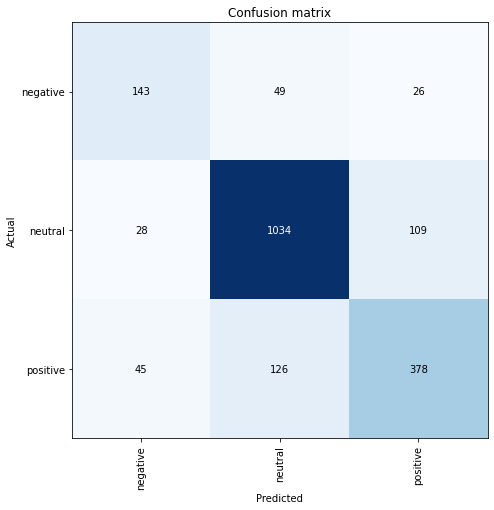

In [153]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(dls_clas.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

#### Test set

In [154]:
#data_test = TextDataLoaders.from_df(df_test, text_col='text', label_col="sentiment", text_vocab=dls_lm.vocab)
test_dl = learn.dls.test_dl(df_test)
preds, y = learn.get_preds()

In [155]:
dl_test = learn.dls.test_dl(df_test, with_labels=True, drop_last=False)
preds = learn.get_preds(dl=dl_test, with_decoded=True)
predictions = preds[2]
targets = preds[1]

In [156]:
#print(preds[2].shape)
#print(preds[1].shape)

In [157]:
def my_accuracy(y_pred, y_true):
    equ = [1 if i == t else 0 for i, t in zip(y_pred, y_true)]
    return np.mean(equ)

In [158]:
acc = my_accuracy(predictions, targets)
print("Test Set Accuracy: ",acc) #0.723

Test Set Accuracy:  0.3698710433763189


In [159]:
from sklearn.metrics import confusion_matrix
confusion_matrix(targets, predictions)

array([[ 162,  960,    7],
       [  81, 1641,   10],
       [ 145, 2022,   90]])

In [160]:
#df_test.text

In [161]:
#Tried cleaning up data: via function clean_text, didn't improve a thing :(

In [162]:
#>>Done>> #Try other model instead of AWD_LSTM > AWD_QRNN. Didnt work. Pytorch error, too complicated fix.: https://forums.fast.ai/t/cant-import-qrnn-or-qrnnlayer/45072/7
#>>Done>> #Try make test set as validation set in classifier.
#>>DONE>> Conclusion: Use test as valid. #See test accuracy change, after proper acc calc now, afte rreverting previous step
#>>DONE>> check the other dataset for LM, not Reuters titles but perhaps better data for LM there
#>>DONE>> #Bloomberg better. But data needs stripping down:
#>>DONE>> #-first rows untill www.bloomberg.com
#>>DONE>> #-last trows from . "To contact the reporters" or/and "NOTE 1:"
#Run the same cleaner preproccessing functions in LM as in train/test data for classifiers.
#Add preproccesing / cleaner functions into the pipeline?